In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn import masking as nimask
from nibabel.processing import resample_to_output
from matplotlib import pyplot as plt

In [2]:
#LOADING IN
#one preprocessed scan
fmri_test_path = 'NYU_0051015_func_preproc.nii'
#nibable image

#fmri_image_path = 'C:/Users/ahmm9/OneDrive - ITU/ITU/Research_proj/prepros_data/Outputs/ccs/filt_global/func_preproc'
fmri_image_path = '../DATA/pre_proc_ABIDE1/func_preproc'
img = nib.load(fmri_test_path).get_fdata()

print(img.shape)
print(f"The .nii files are stored in memory as numpy's: {type(img)}.")


#parcellation mask
mask_path = 'Yeo2011_7Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii'
img2 = nib.load(mask_path).get_fdata()
img2.shape


(61, 73, 61, 175)
The .nii files are stored in memory as numpy's: <class 'numpy.memmap'>.


(256, 256, 256, 1)

Plot data and mask

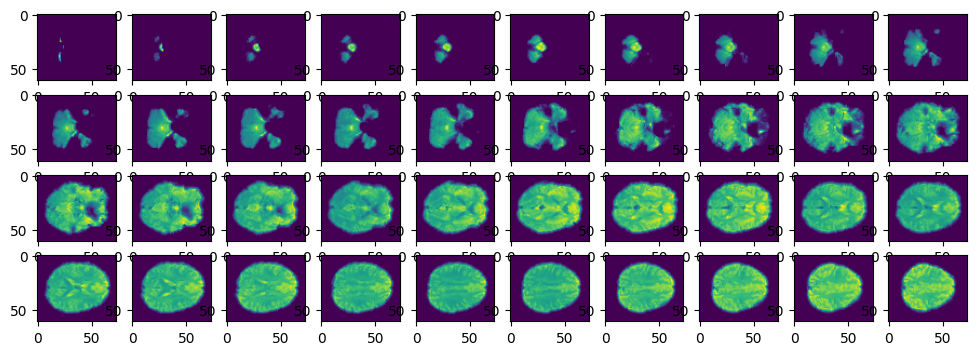

In [3]:
plt.style.use('default')
fig, axes = plt.subplots(4, 10, figsize=(12, 4))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img[:, :, i, 0])
plt.show()

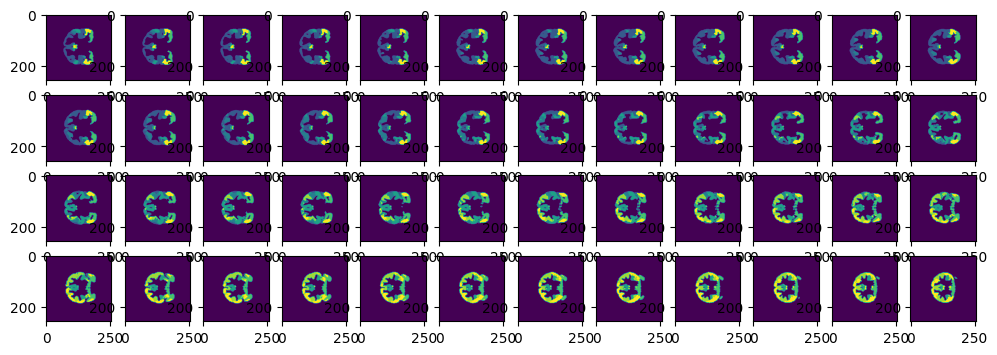

In [4]:
plt.style.use('default')
fig, axes = plt.subplots(4, 12, figsize=(12, 4))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img2[:, :, 125 + i, 0])  
    # Start from the 31st image (index 30)#TODO still this with different indexing??
plt.show()


In [5]:
# #separate mask values #OLD
# def create_masks(dataset):
#     masks = {}
#     for value in range(1, 8):  # Assuming values are between 1 and 7
#         masks[value] = dataset == value
#     return masks

# masks = create_masks(img2)

# print(masks[1].shape)

In [6]:
# plt.style.use('default')
# fig, axes = plt.subplots(32, 4, figsize=(10, 10))
# for i, ax in enumerate(axes.reshape(-1)):
#     ax.imshow(masks[1][:, :, i, 0])  
# plt.show()

In [7]:
#load with NILearn
ni_image = nimg.load_img(fmri_test_path)
ni_mask = nimg.load_img(mask_path)
ni_image.shape
ni_mask.shape

(256, 256, 256, 1)

In [8]:
ni_image.affine

array([[  -3.,   -0.,   -0.,   90.],
       [  -0.,    3.,   -0., -126.],
       [   0.,    0.,    3.,  -72.],
       [   0.,    0.,    0.,    1.]])

In [9]:
#nilearn reshape dims of mask to match
reshaped_mask = nimg.resample_img(ni_mask,target_affine=ni_image.affine, interpolation='nearest',target_shape=ni_image.shape[:3])
reshaped_mask.shape

(61, 73, 61, 1)

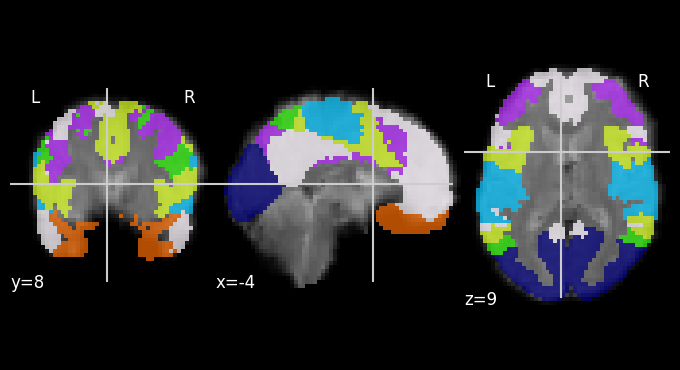

In [10]:
#plot the mask onto one slice of the frmi image
nplot.plot_roi(reshaped_mask, ni_image.slicer[:,:,:,54])

In [11]:
#separate the regions of the mask
def create_parcellation_masks(nifti_mask, nifti_image):
    # Load the data from the Nifti image
    data = nifti_mask.get_fdata().astype(int)
    
    # Create a dictionary to store each mask
    masks = {}
    for value in range(1, 8):  # Assuming values are between 1 and 7
        masks[value] = nib.Nifti1Image((data == value).astype(float), nifti_image.affine) # Create a mask for each unique value
    return masks

mask_dict = create_parcellation_masks(reshaped_mask,ni_image)
print(type(mask_dict[1]))
print(mask_dict[1].shape)

<class 'nibabel.nifti1.Nifti1Image'>
(61, 73, 61, 1)


In [12]:
mask_reasonable_shape = reshaped_mask.get_fdata().astype(int)[:,:,:,0]
not_brain = (mask_reasonable_shape == 0).sum()
brain = (mask_reasonable_shape != 0).sum()
print(brain,not_brain) # not brain is relative to parcellation
print((brain/(brain+not_brain))*100,"%")

39080 232553
14.387059009766853 %


In [13]:
ni_image.shape

(61, 73, 61, 175)

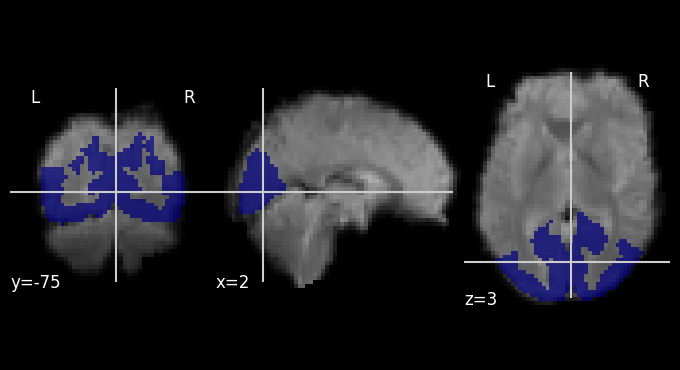

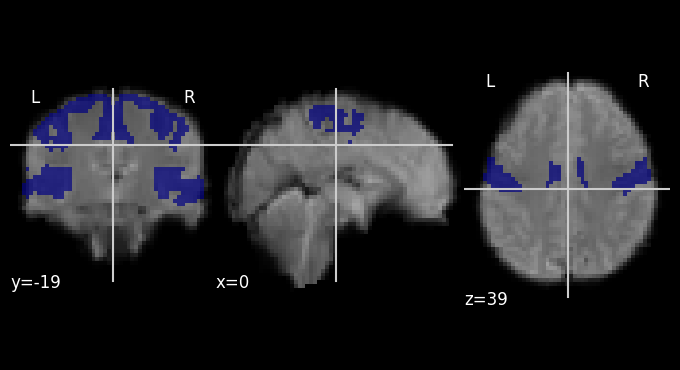

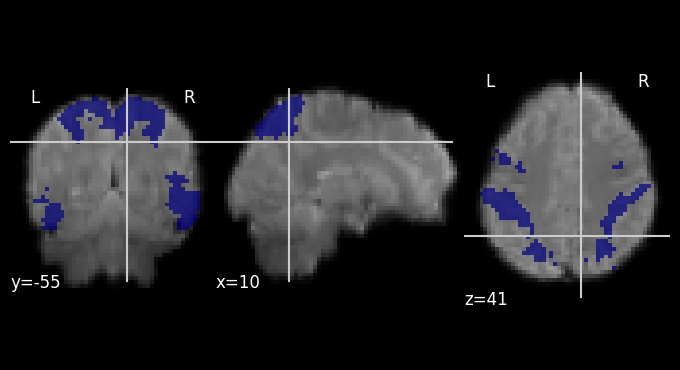

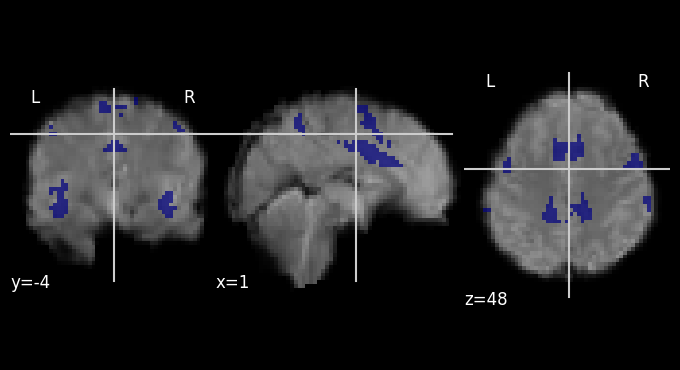

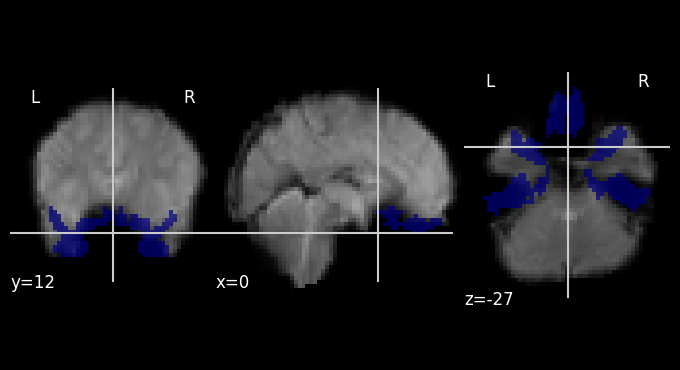

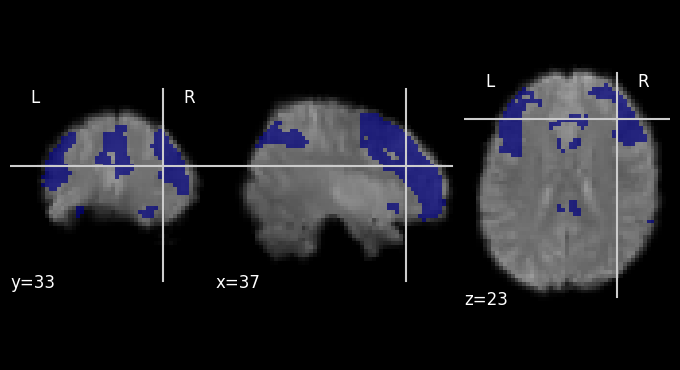

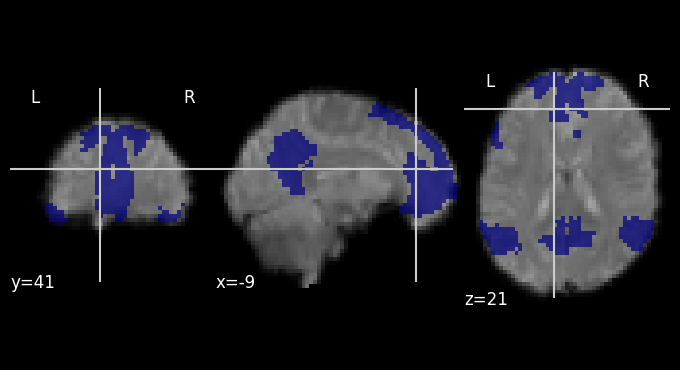

[array([10075.39  , 10074.992 , 10074.491 , 10082.858 , 10095.274 ,
       10105.432 , 10110.004 , 10109.022 , 10104.414 , 10099.248 ,
       10097.833 , 10103.106 , 10113.103 , 10120.424 , 10117.925 ,
       10105.585 , 10091.256 , 10082.987 , 10080.67  , 10076.701 ,
       10064.493 , 10046.877 , 10034.418 , 10035.756 , 10049.934 ,
       10067.762 , 10079.961 , 10083.702 , 10082.502 , 10081.886 ,
       10085.621 , 10094.298 , 10105.137 , 10112.806 , 10111.964 ,
       10101.382 , 10085.984 , 10074.216 , 10071.893 , 10078.117 ,
       10087.399 , 10094.533 , 10097.844 , 10098.337 , 10097.377 ,
       10096.247 , 10096.617 , 10099.192 , 10102.0205, 10101.317 ,
       10095.737 , 10089.578 , 10089.365 , 10096.446 , 10103.728 ,
       10101.859 , 10089.389 , 10074.999 , 10068.774 , 10071.983 ,
       10076.677 , 10075.641 , 10070.743 , 10069.914 , 10076.501 ,
       10084.889 , 10087.133 , 10082.585 , 10078.873 , 10082.606 ,
       10092.192 , 10101.025 , 10106.001 , 10110.212 , 10116.

In [14]:
#apply mask
output = {}
means_no_threshold = []
voxelsum = 0
for i in range(1,8):
    output[i] = nimask.apply_mask(ni_image, mask_dict[i])
    nplot.plot_roi(mask_dict[i], ni_image.slicer[:,:,:,54])
    nplot.show()
    voxelsum += np.sum(output[i])
    means_no_threshold.append(np.mean(output[i], axis = 1))
    
print(means_no_threshold)
print(means_no_threshold[1].shape)
print(brain)
print(voxelsum)
threshold = voxelsum/brain
print(threshold)

In [15]:
def apply_mask(image,mask):
    output_dict = {}
    for i in range(1,8):
        output_dict[i] = nimask.apply_mask(image, mask[i])
    return output_dict

output2 = apply_mask(ni_image,mask_dict)
print(output2[1].shape)
print(np.array_equal(output[1], output2[1]))

        

(175, 6582)
True


In [16]:
import os

def compute_voxel_count(data, t):
    voxel_count = 0
    for key in data.keys():
        voxel_count += len(data[key][t])
    return voxel_count

print(compute_voxel_count(output,5))


39080


In [17]:
#get all images into list #TODO get from fmri_image_path
all_images = []
seg = pd.read_csv("../DATA/ABIDE/NYU_1/phenotypic_NYU.csv")
label = []
for filename in os.listdir(fmri_image_path):
    if filename.endswith('.nii') or filename.endswith('.nii.gz'):
        file_path = os.path.join(fmri_image_path, filename)
        label.append(int(seg[seg["SUB_ID"]==int(filename[6:11])]["DX_GROUP"]))
        img = nimg.load_img(file_path)
        all_images.append(img)
print(np.array(all_images).shape)

#1:30 runtime, use paths instead if only running some


(171,)


In [18]:
#check affine is same for all images
print(len(all_images))
prev_img = all_images[0]
for img in all_images:
    if (prev_img.affine != img.affine).all():
        print("different")
    prev_img = img

171


In [19]:
import pickle

In [20]:
# threshold finder
# all group region all time
# all region averages, all participants

In [21]:
all_masked_images = []
start_index = 0
# running mask apply, save every 10th iteration, can be restarted and interrupted
try:
    with open('masked_image.pkl', 'rb') as f:
        print(f)
        all_masked_images = pickle.load(f)
        start_index = len(all_masked_images)
        print(f"Resuming from index {start_index}")
except FileNotFoundError:
    print("No previous save found, starting from scratch")
    
for i in range(start_index,len(all_images)):
    all_masked_images.append(apply_mask(all_images[i],mask_dict))
    if (i % 10 == 0):
        with open('masked_image.pkl', 'wb') as f:
            pickle.dump(all_masked_images,f)
        print("saved at index", i)

print("Applied mask to all images")

print(len(all_images) == len(all_masked_images))
print(all_images[0].shape[3] == len(all_masked_images[0][1]))

<_io.BufferedReader name='masked_image.pkl'>
Resuming from index 171
Applied mask to all images
True
True


In [22]:
#if timesteps isnt the same the calculaitons need to be weighted
# this bit checks all scans are 175 timesteps long
for i in range(len(all_images)):
    if all_images[i].shape[3] != 175:
        print( all_images[i] )

In [ ]:
def threshold_per_timestep(data,time_steps):
    """each participant, each timestep"""
    thresholds = np.zeros((len(data),time_steps))
    for i in range(len(data)):
        for t in range(time_steps):
            voxel_sum = 0
            voxel_count = compute_voxel_count(data[i],t)
            for key in (data[i].keys()):
                voxel_sum += np.sum(data[i][key][t])  
            mean = voxel_sum/voxel_count
            thresholds[i][t] = mean
    return thresholds

#Bit of a shit way to do it. Just take average within the bin instead
def threshold_per_bin(data,bin_size, time_steps):
    """each participant, each bin (div by 5 is easiest)"""
    time_steps = int(time_steps/bin_size)
    thresholds = np.zeros((len(data),time_steps))
    for i in range(len(data)):
        for t in range(time_steps):
            voxel_sum = 0
            index_offset = t * bin_size
            voxel_count = 0
            for b in range(bin_size):
                voxel_count += compute_voxel_count(data[i],index_offset+b)  
                for key in (data[i].keys()):
                    voxel_sum += np.sum(data[i][key][index_offset+b])  
            mean = voxel_sum/voxel_count
            thresholds[i][t] = mean
    return thresholds

def threshold_per_participant(data,time_steps):
    """each participant, whole timeframe"""
    thresholds = np.zeros((len(data)))
    for i in range(len(data)):
        voxel_sum = 0
        voxel_count = compute_voxel_count(data[i],1) * time_steps 
        for key in (data[i].keys()):
            voxel_sum += np.sum(data[i][key])
        mean = voxel_sum/voxel_count
        thresholds[i] = mean
    return thresholds

# def threshold_participant_region_all_time(data):
#     all_thesholds = []
#     for participant in range(len(data)):
#         print(participant)
#         l_thresholds = [0 for i in range(len(data[0].keys()))] # set to 0 for all regions
#         for i in range(len(l_thresholds)):
#             # print(f"{i}:")
#             # voxels in the mask by number of timesteps by number of participants in group
#             voxel_count = len(data[0][i+1][0]) * len(data[0][i+1]) * sum(labels == l)

#             voxel_sum = 0
#             for participant in range(len(data)):
#                 if labels[participant] == l: # only within group

#                 #print(len(data[participant][i+1]))
#                 #print(np.sum(data[participant][i+1]))
#                     voxel_sum += np.sum(data[participant][i+1])#[participant][region]
#             l_thresholds[i] = voxel_sum/voxel_count
#             all_thresholds.append(l_thresholds)
#     return all_thresholds


def threshold_groups_region_all_time(data,labels):
    labels = np.array(labels)
    all_thresholds = dict()
    for l in set(labels):
        l_thresholds = [0 for i in range(len(data[0].keys()))] # set to 0 for all regions
        for i in range(len(l_thresholds)):
            # print(f"{i}:")
            # voxels in the mask by number of timesteps by number of participants in group
            voxel_count = len(data[0][i+1][0]) * len(data[0][i+1]) * sum(labels == l)

            voxel_sum = 0
            for participant in range(len(data)):
                if labels[participant] == l: # only within group

                #print(len(data[participant][i+1]))
                #print(np.sum(data[participant][i+1]))
                    voxel_sum += np.sum(data[participant][i+1])#[participant][region]
            l_thresholds[i] = voxel_sum/voxel_count
        all_thresholds[l]=l_thresholds
    return all_thresholds


In [ ]:
#1  is autism 2 is TD/control
threshold_rat = threshold_participant_region_all_time(all_masked_images)
threshold_grat = threshold_groups_region_all_time(all_masked_images,label)
#threshold_grat
threshold_rat

<function __main__.threshold_participant_region_all_time(data, labels)>

In [25]:
threshold_timestep = threshold_per_timestep(all_masked_images,175)
print("timestep: ", threshold_timestep.shape)
    
bin_size = 5
threshold_bin = threshold_per_bin(all_masked_images,bin_size,175)
print("bin: ", threshold_bin.shape)

threshold_participant = threshold_per_participant(all_masked_images,175)
print("participant: ", threshold_participant.shape)

timestep:  (171, 175)
bin:  (171, 35)
participant:  (171,)


In [26]:
len(all_masked_images[0].keys())

7

In [ ]:
def binarise(data,labels,thresholds):
    labels = np.array(labels)
    for_eda_by_group = {1:[],2:[]}
    for scan_num,one_scan in enumerate(data):
        image_label = labels[scan_num]
        one_image_bin = np.array(pd.DataFrame.from_dict(binarize_one_image (one_scan,thresholds[image_label]),orient="index"))
        #print(one_image_bin.shape)
        for_eda_by_group[image_label].append(one_image_bin)
    for group in for_eda_by_group:
        for_eda_by_group[group] = np.concatenate(for_eda_by_group[group],axis=1,dtype=int)


    return for_eda_by_group


def binarize_one_image(image,thresholds):
    means_with_threshold = dict()
    for i in image.keys():
        # print(i)
        # print(image[i].shape)
        # print(len(np.mean(image[i], axis = 1)))
        #print(np.mean(image[i], axis = 1))
        # print(thresholds,i,thresholds[i-1])
        # print(np.mean(image[i], axis = 1)-thresholds[i-1])
        print(image.keys())
        print(i,thresholds[i-1])
        mean_image = (np.mean(image[i], axis = 1))-thresholds[i-1]
        bin_image = np.where(mean_image>0, 1,-1)
        print(sum(bin_image))
        # print(bin_image)
        means_with_threshold[i] = bin_image
    #print(means_no_threshold)
    return means_with_threshold

In [110]:
binarized = binarise(all_masked_images,label,threshold_grat)
binarized[1].shape

dict_keys([1, 2, 3, 4, 5, 6, 7])
1 9874.018416163159
175
dict_keys([1, 2, 3, 4, 5, 6, 7])
2 11005.283481025459
175
dict_keys([1, 2, 3, 4, 5, 6, 7])
3 10367.181699676614
-175
dict_keys([1, 2, 3, 4, 5, 6, 7])
4 12139.078285479181
135
dict_keys([1, 2, 3, 4, 5, 6, 7])
5 5815.832311228826
-175
dict_keys([1, 2, 3, 4, 5, 6, 7])
6 11051.503775730938
-175
dict_keys([1, 2, 3, 4, 5, 6, 7])
7 11020.181019350674
-175
dict_keys([1, 2, 3, 4, 5, 6, 7])
1 9874.018416163159
-175
dict_keys([1, 2, 3, 4, 5, 6, 7])
2 11005.283481025459
175
dict_keys([1, 2, 3, 4, 5, 6, 7])
3 10367.181699676614
175
dict_keys([1, 2, 3, 4, 5, 6, 7])
4 12139.078285479181
175
dict_keys([1, 2, 3, 4, 5, 6, 7])
5 5815.832311228826
-175
dict_keys([1, 2, 3, 4, 5, 6, 7])
6 11051.503775730938
175
dict_keys([1, 2, 3, 4, 5, 6, 7])
7 11020.181019350674
-175
dict_keys([1, 2, 3, 4, 5, 6, 7])
1 9874.018416163159
175
dict_keys([1, 2, 3, 4, 5, 6, 7])
2 11005.283481025459
-175
dict_keys([1, 2, 3, 4, 5, 6, 7])
3 10367.181699676614
-175
dict_keys(

(7, 12775)

In [104]:
#save
for i in binarized.keys():
    np.savetxt(f"Binarized_Data_Group_{i}",binarized[i],fmt="%d",delimiter=",")

In [ ]:
#TODO:
# binarise
# is threshold different by group??? and perticipant?? and variance
# save the data, separate data by groups (structure)
# threshold by region
# sliding timeframes
# binsize
# concatenation of groups
# writing
# formatting of notebook


In [ ]:
# mean_activations = np.array(means)
# mean_activations.shape
# threshold